In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from tqdm import tqdm

import sys
sys.path.append("../src")

from data_prep import *
from make_cuts import *
from fitting_functions import *
from pulse_profile_generator import *
from plot_maker import *
from pulse_plot_maker import *

In [2]:
pd.set_option('display.max_columns', None)

In [34]:
c_folder="../../data/calibration/"
d_folder="../../data/runData/"
r_n=287
pulsed=True

Path("../../plots").mkdir(parents=True, exist_ok=True)
Path("../../plots/run_"+str(r_n)).mkdir(parents=True, exist_ok=True)
p_folder="../../plots/run_"+str(r_n)+"/"

In [35]:
%%time
p,m,r=import_data(c_folder,d_folder, r_n, is_it_pulsed=pulsed)

CPU times: user 6.47 s, sys: 974 ms, total: 7.44 s
Wall time: 8.22 s


In [36]:
%%time
r=select_bars_with_data(r,p, subtract_pedestal=True, is_it_pulsed=pulsed) #this needs to be run as it's own cell

Number of events: 7800


Initial pedestal-based selection performed.
Events left: 7764


CPU times: user 584 ms, sys: 248 ms, total: 832 ms
Wall time: 891 ms


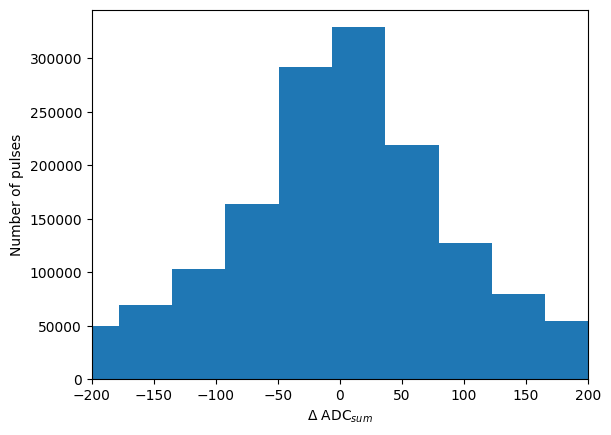

In [33]:
plt.hist(r["adc_sum_end0"]-r["adc_sum_end1"], bins=200)
# plt.ylim(0,50)
# plt.yscale('log')
plt.xlabel(r"$\Delta$ ADC$_{sum}$")
plt.xlim(-200,200)
plt.ylabel("Number of pulses")
plt.show()

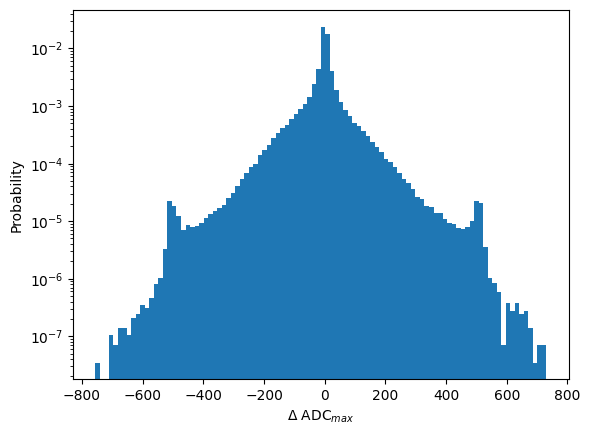

In [18]:
plt.hist((r["adc_max_end0"]-r["adc_max_end1"]), bins=100, density=True)
# plt.ylim(0,50)
plt.yscale('log')
plt.xlabel(r"$\Delta$ ADC$_{max}$")
plt.ylabel("Probability")
plt.show()

In [37]:
sick_bar=r[(r["layer"]==16) & (r["strip"]==8)]

In [25]:
# can only be ran if pulsed==True
# plot_pulse(4,r, p_folder,False)

In [7]:
# dropping unnecessary columns
r=pulse_drop_extra_cols(r, pulsed)

In [38]:
pulse_df=pd.read_csv(d_folder+"run_"+str(r_n)+"_pulse_problems.csv", index_col="index")

In [39]:
big_df=r.merge(pulse_df, left_index=True, right_index=True)

In [40]:
sick_bar_df=sick_bar.merge(pulse_df, left_index=True, right_index=True)

In [41]:
weird_stuff_indices=sick_bar_df[sick_bar_df["has_problem"]==1].index

In [42]:
sick_bar_df.rename(columns={'layer_y': 'layer'}, inplace=True)

SPIKE_1


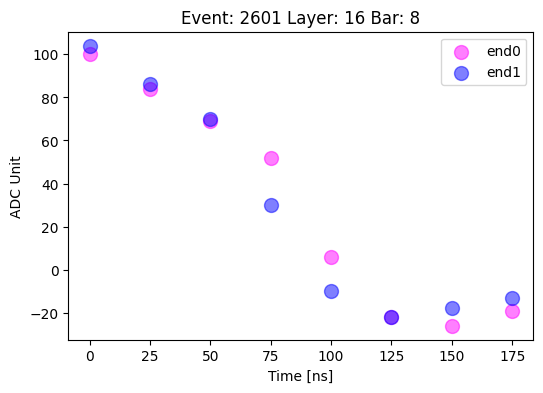

LATE


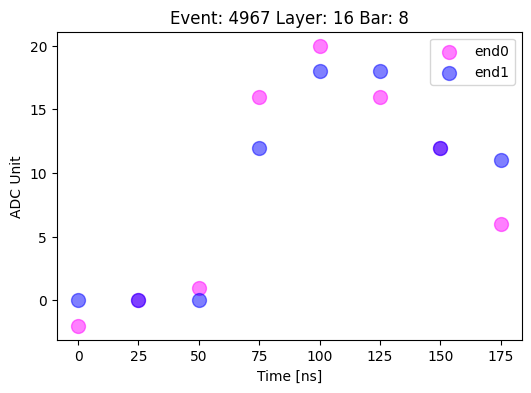

LATE


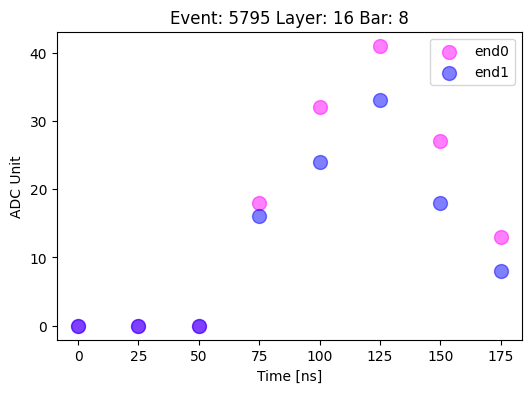

SPIKE_0


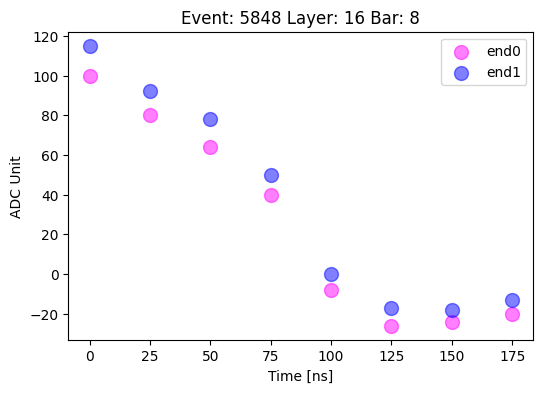

WAVE


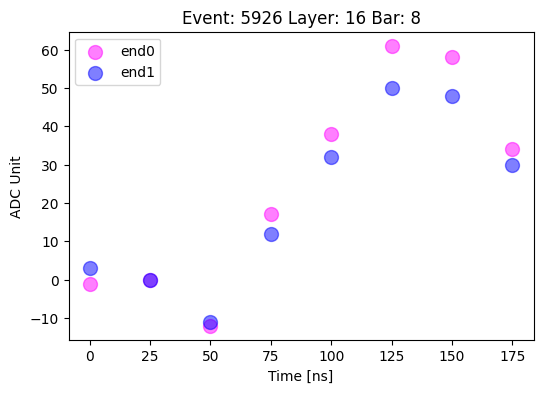

WAVE


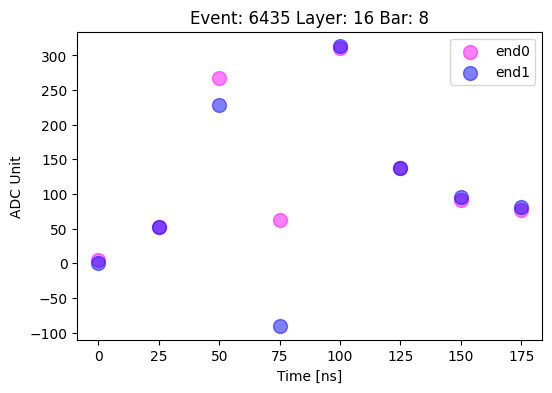

SPIKE_0


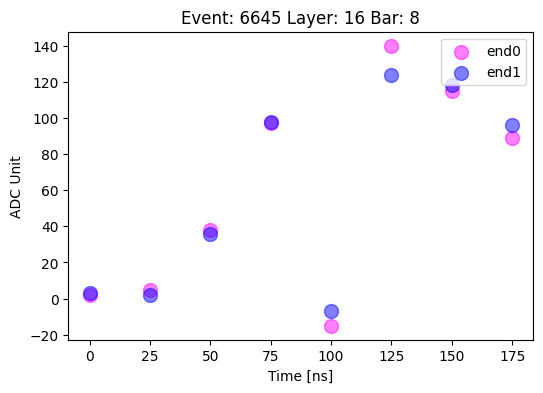

WAVE


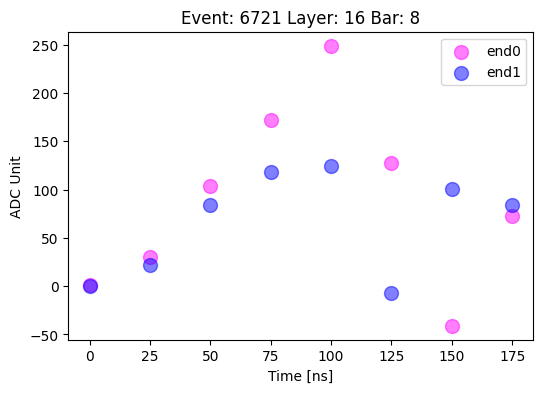

LATE


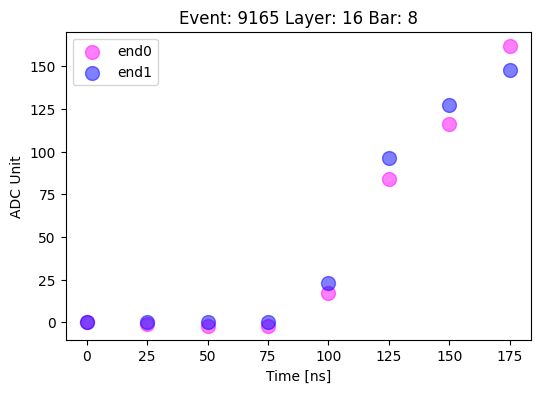

SPIKE_0


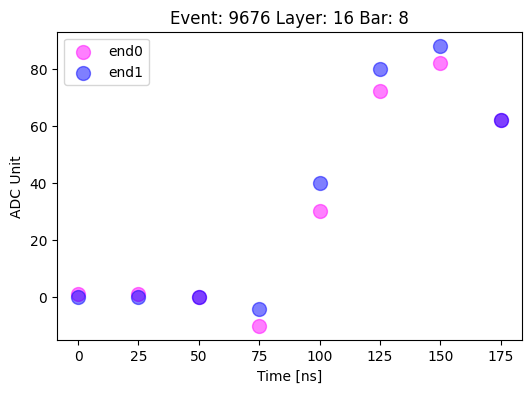

In [43]:
plt.rcParams["figure.figsize"]=(6,4)
for i in weird_stuff_indices:
    print(sick_bar_df.loc[i]["problem_type"])
    plot_pulse(i,sick_bar_df,False)

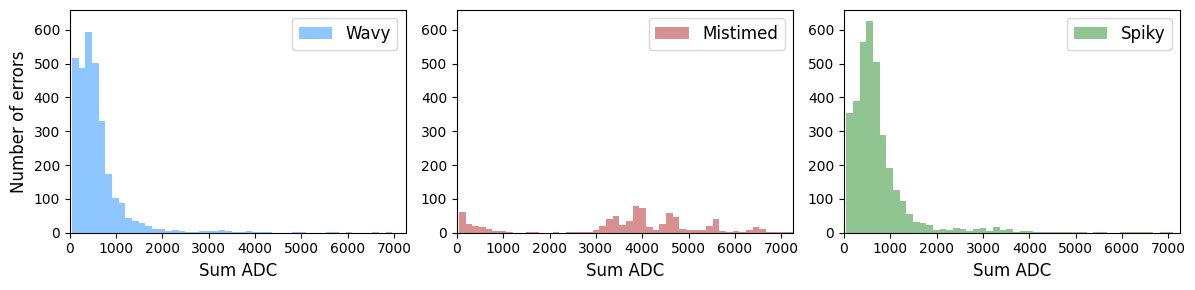

In [29]:
plot_error_by_energy(big_df, False,p_folder, False)

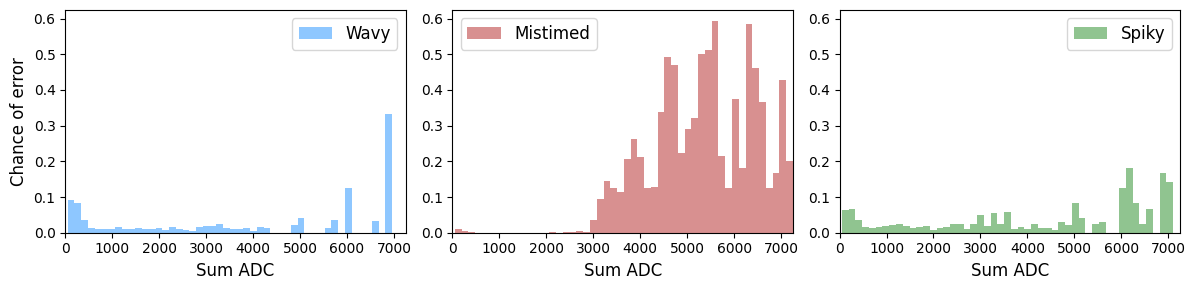

In [30]:
plot_error_by_energy(big_df, True,p_folder, False)

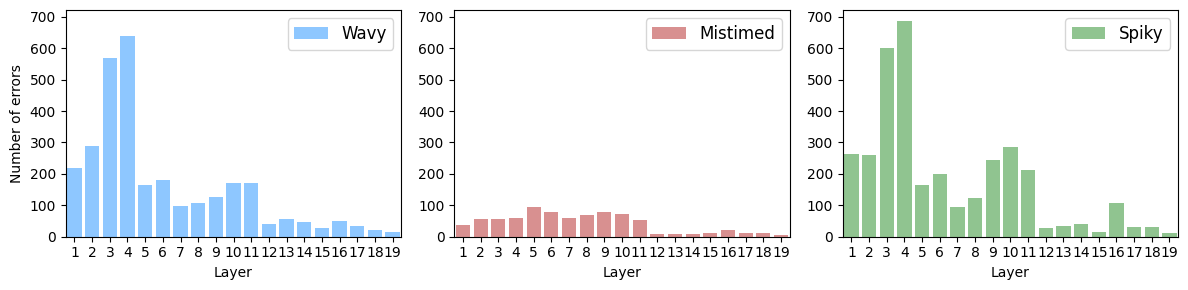

In [31]:
plot_error_by_layer(big_df, False, p_folder,False)

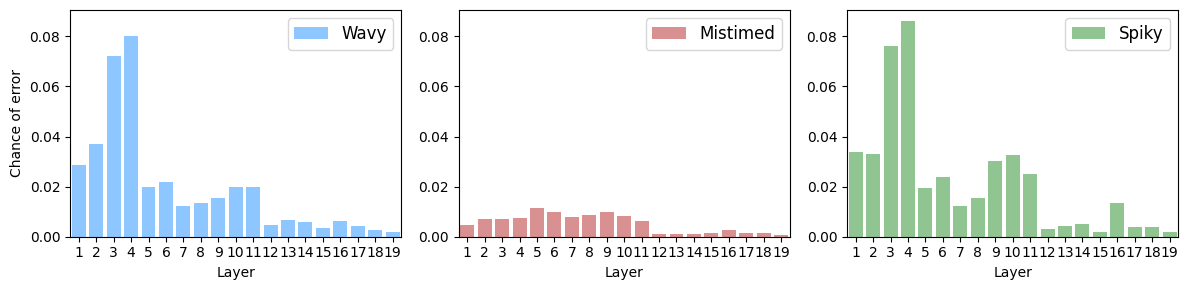

In [32]:
plot_error_by_layer(big_df, True,p_folder, False)

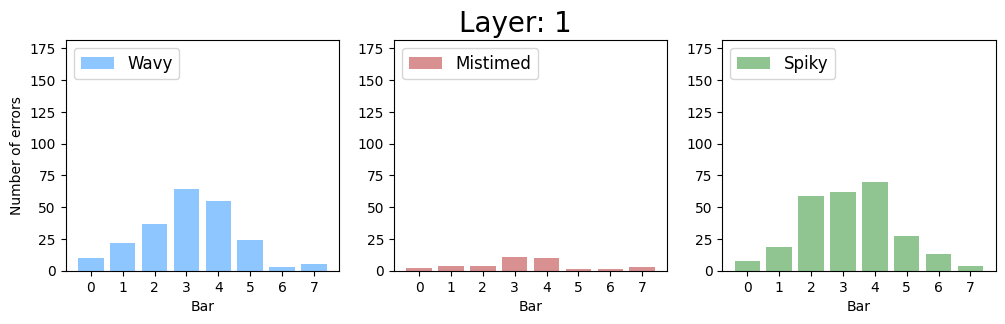

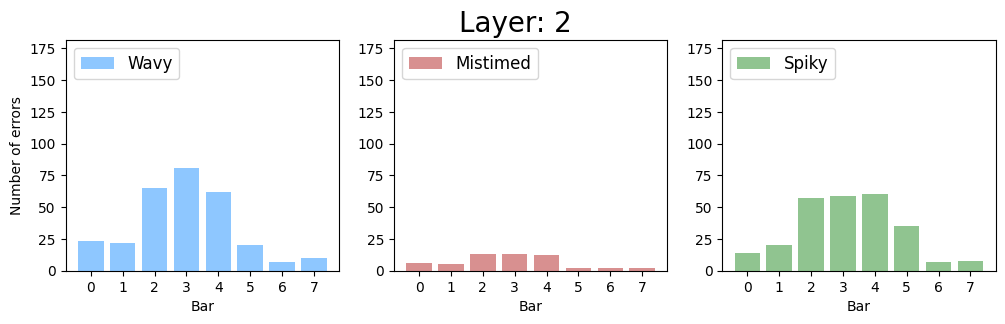

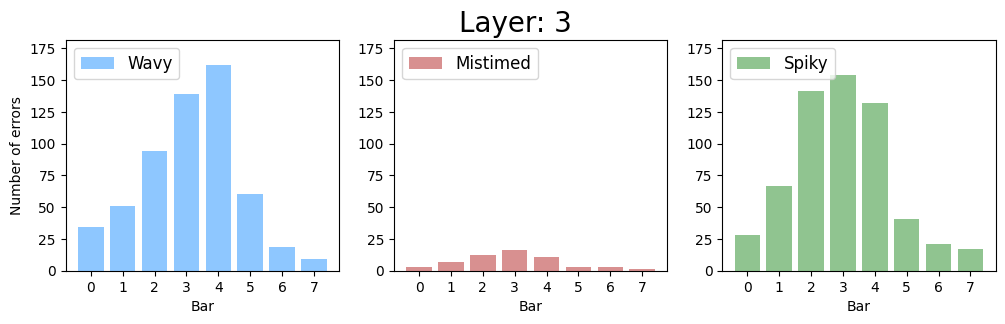

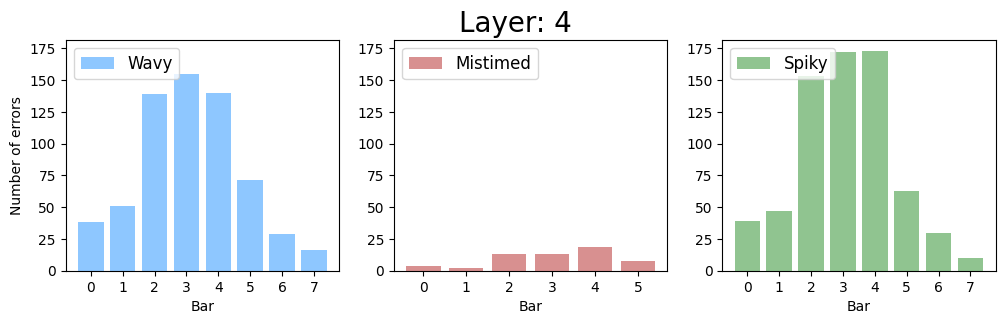

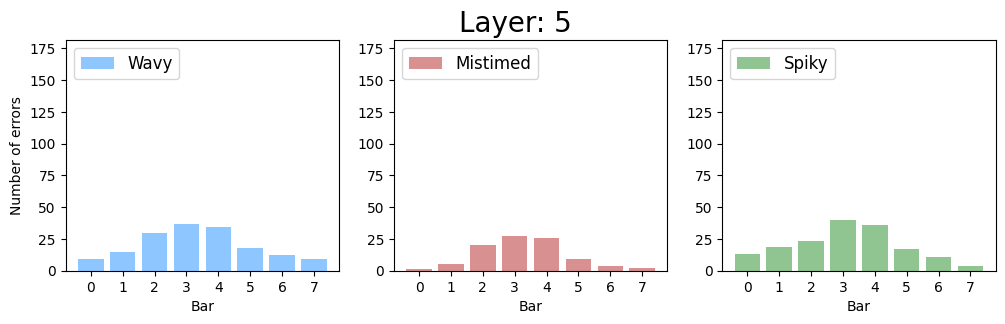

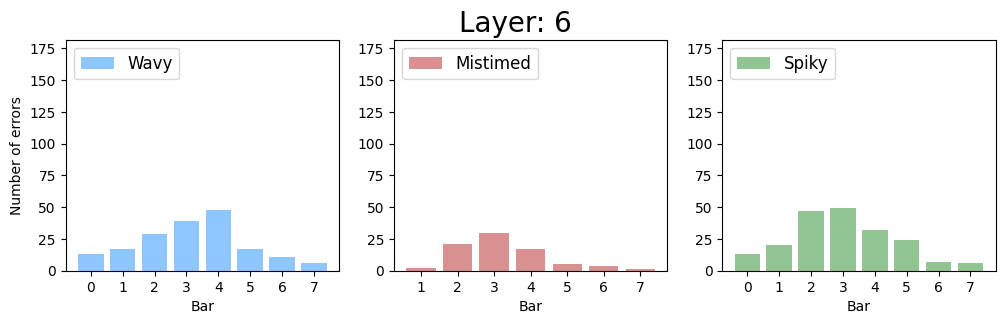

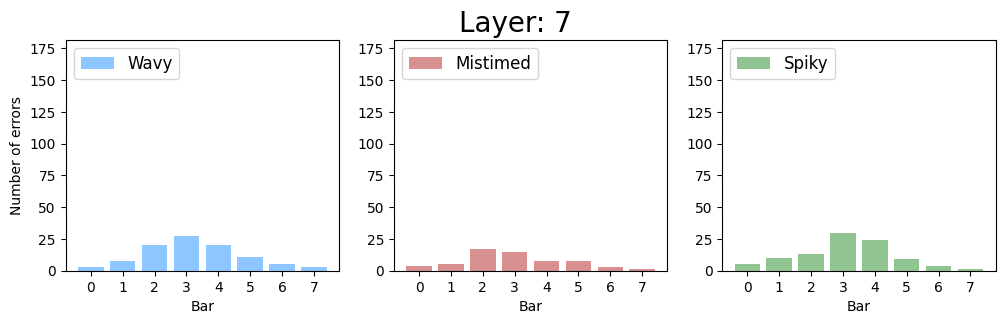

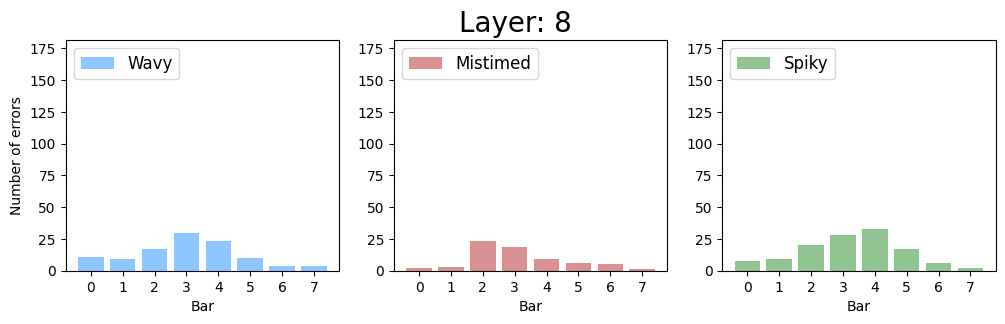

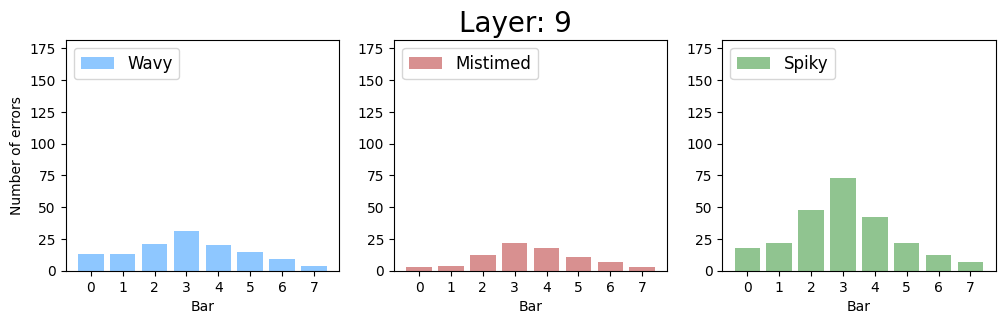

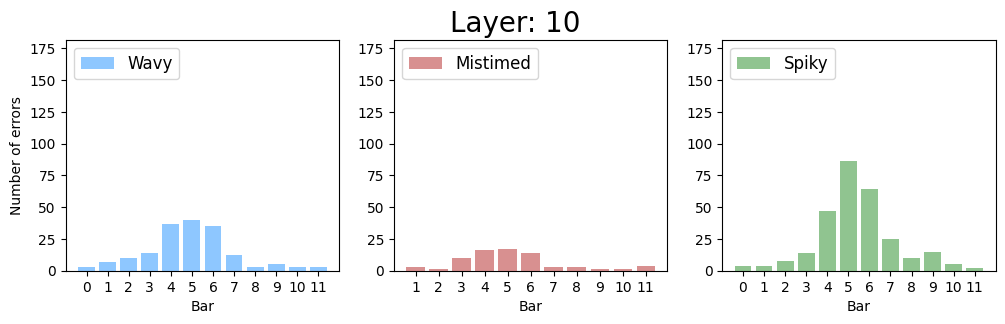

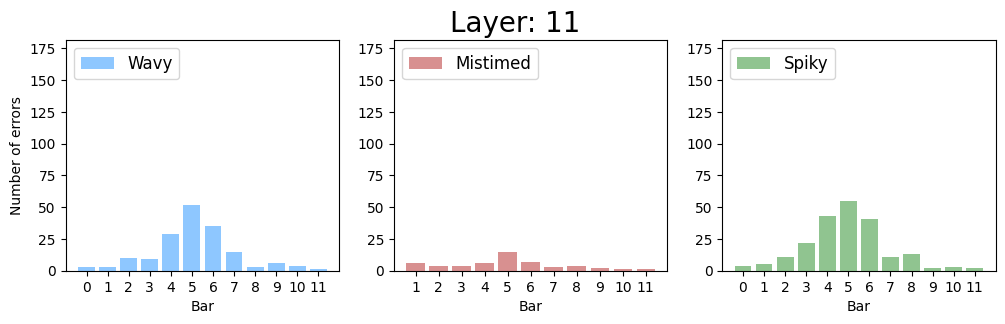

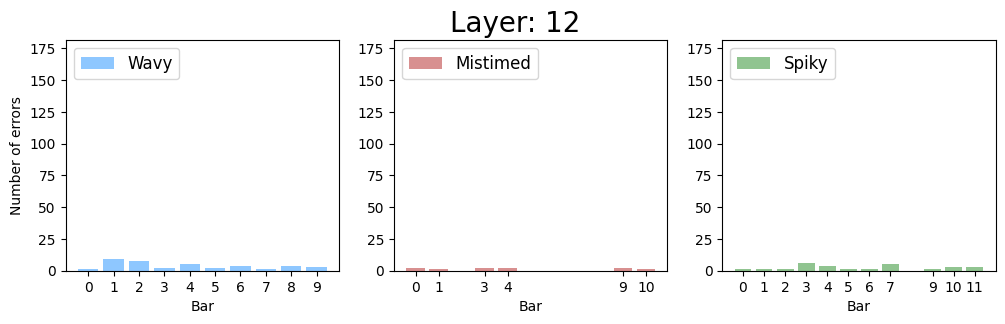

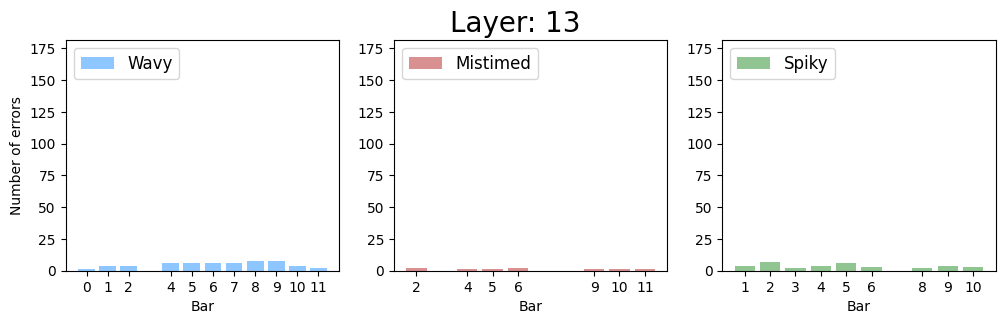

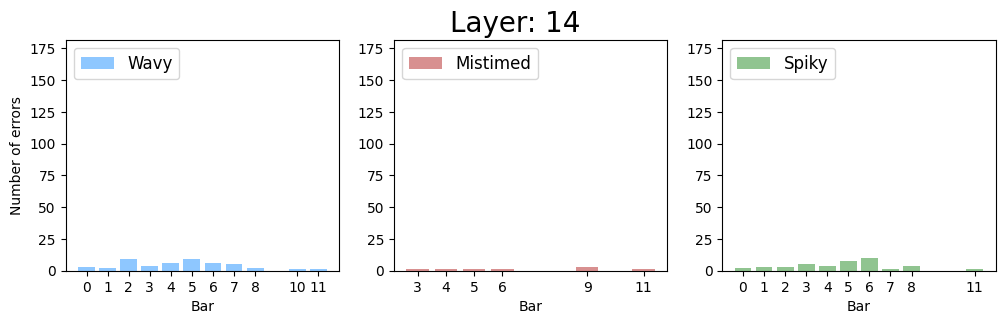

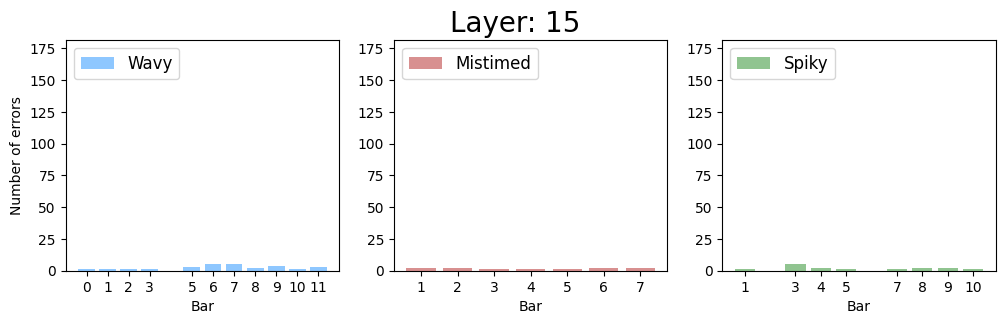

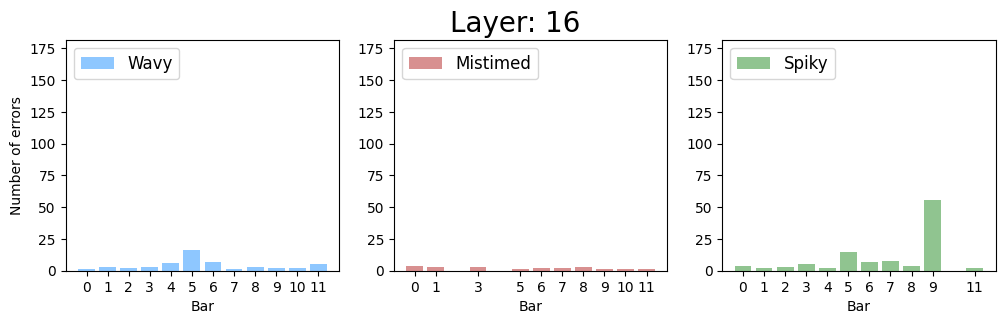

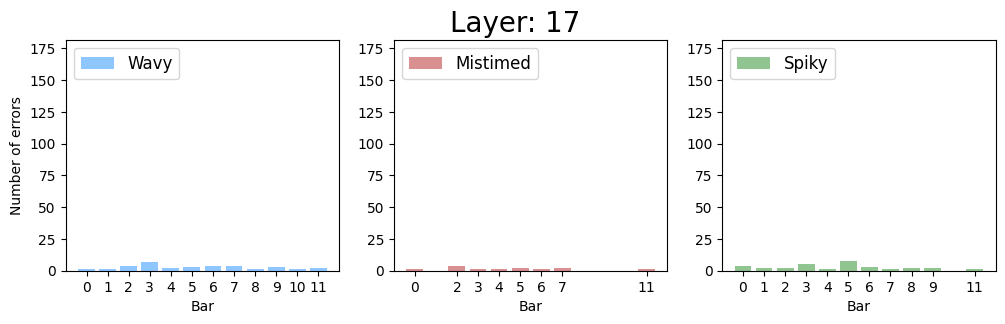

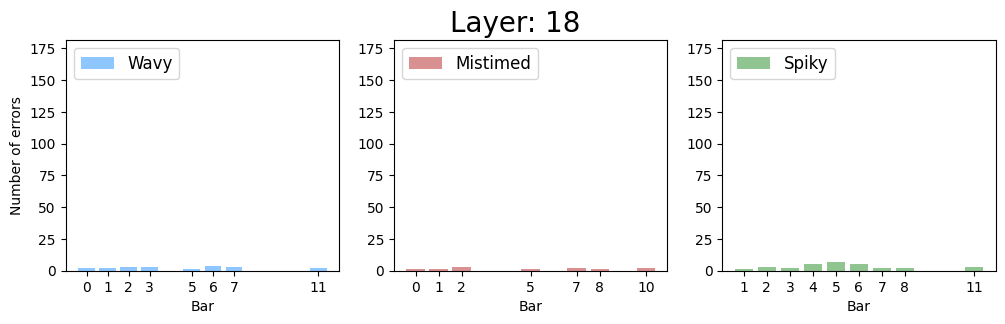

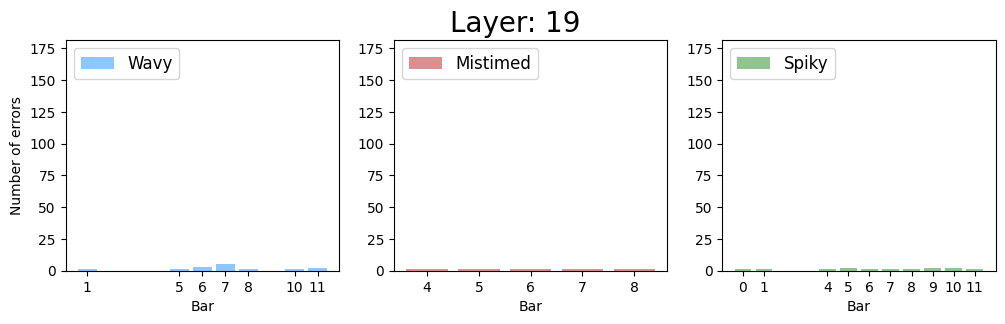

In [33]:
plot_error_by_bar(big_df, False,p_folder, False)

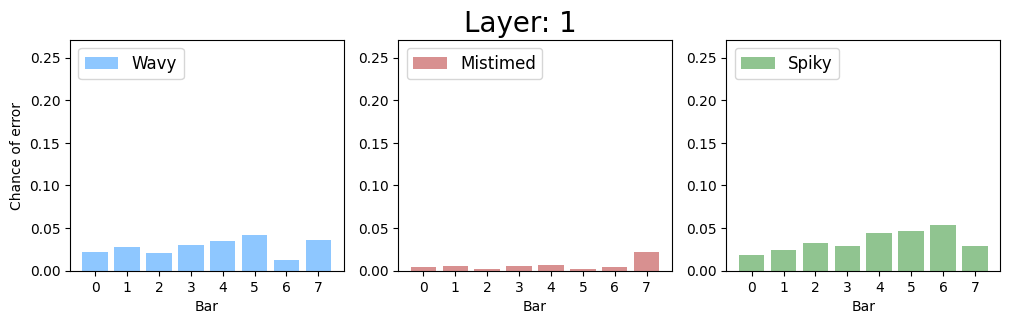

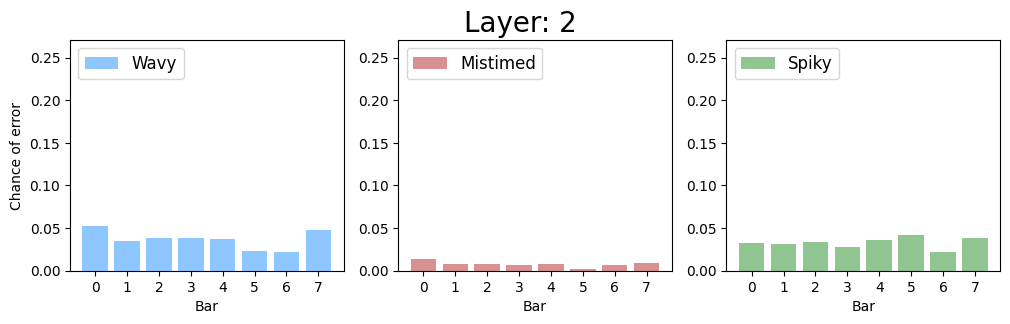

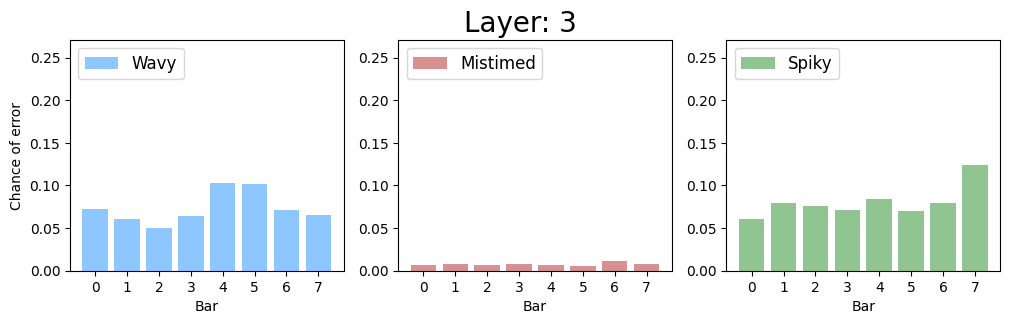

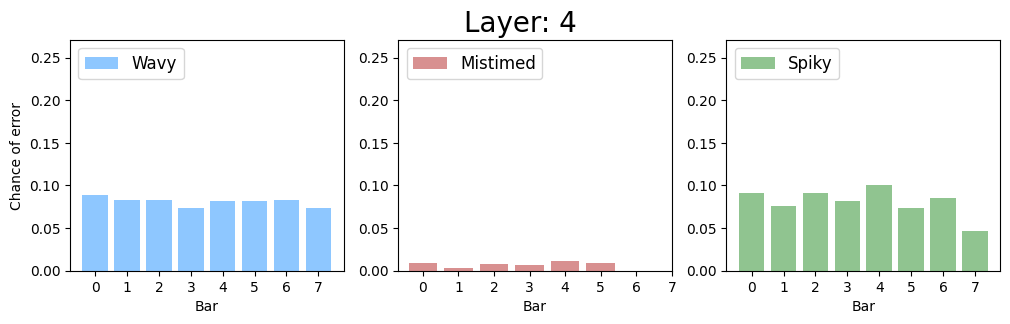

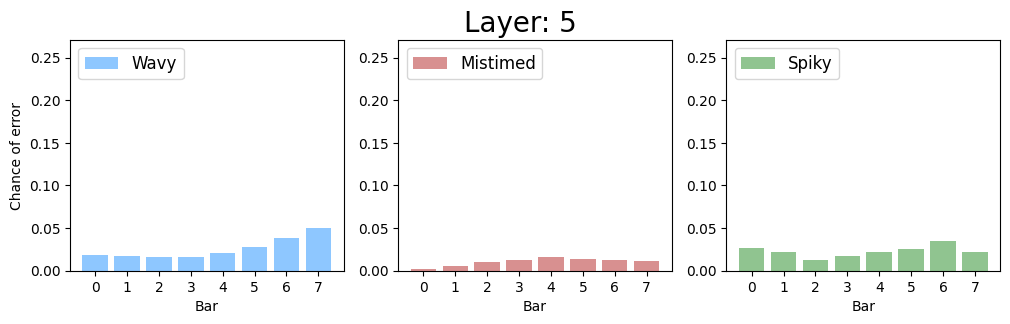

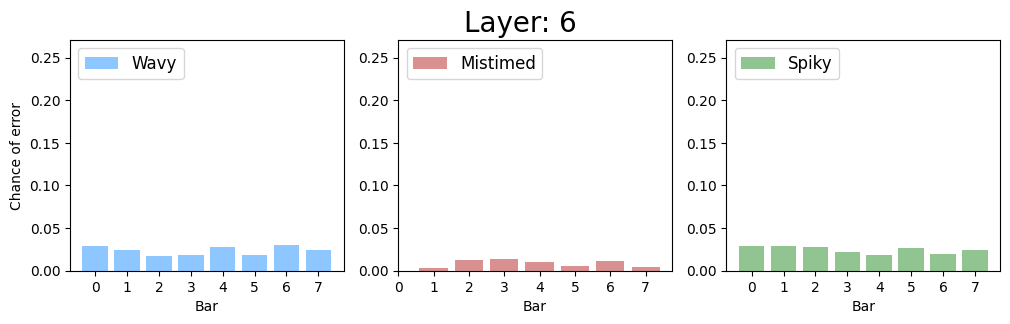

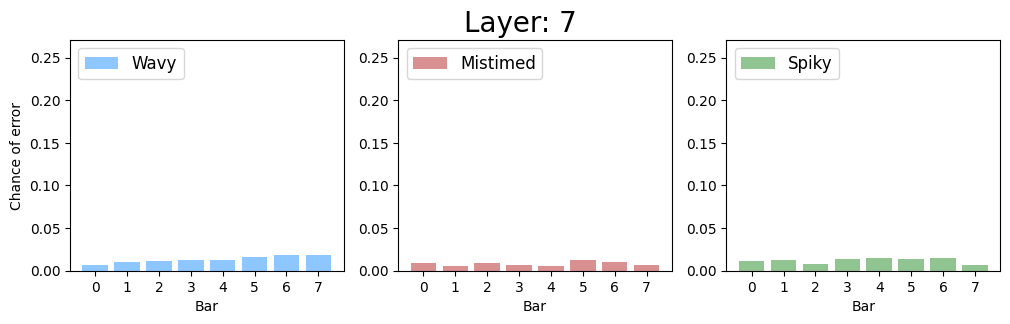

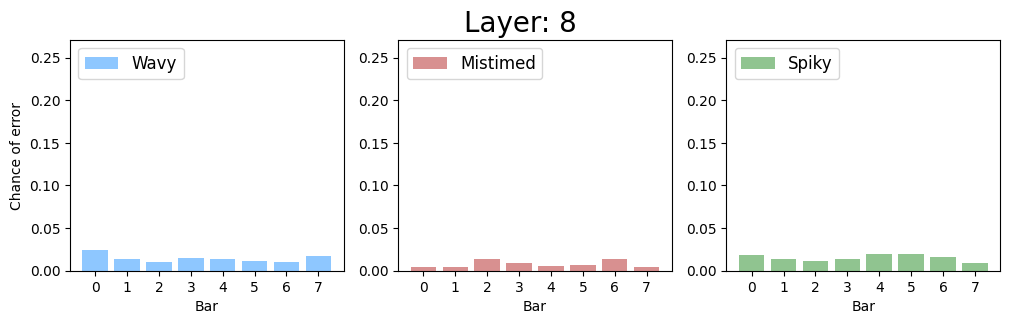

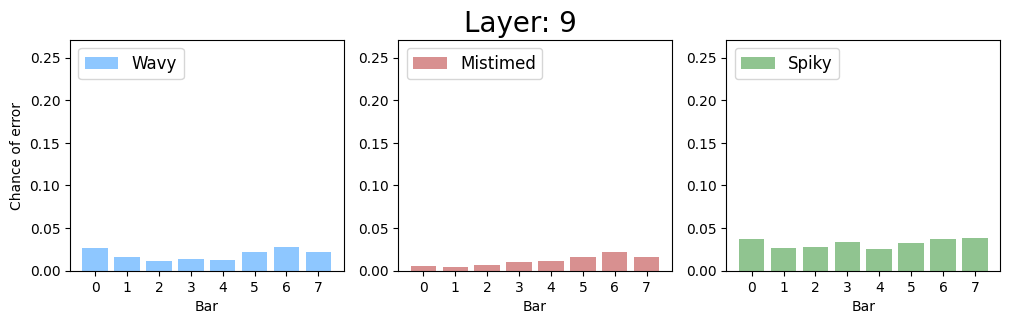

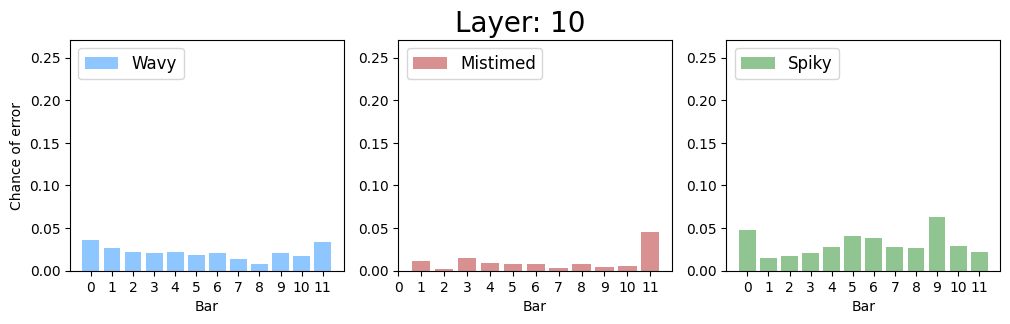

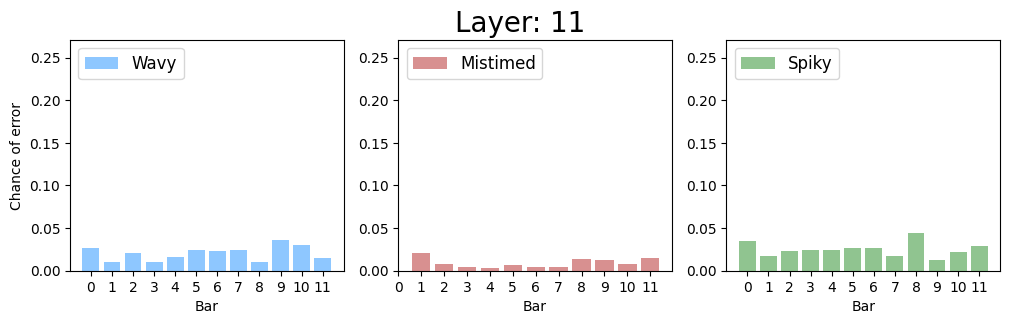

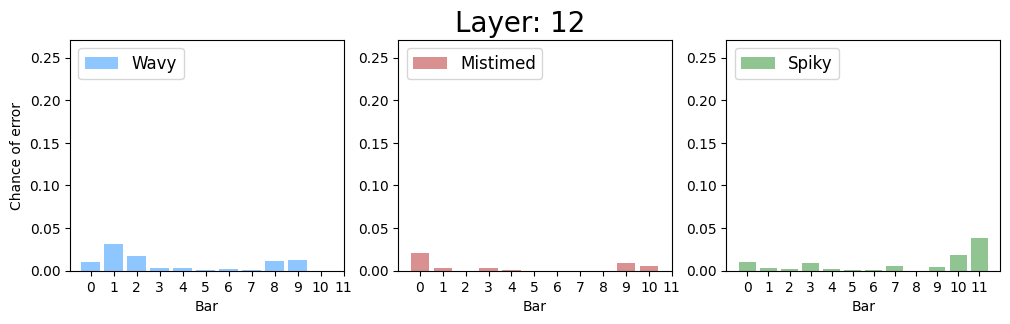

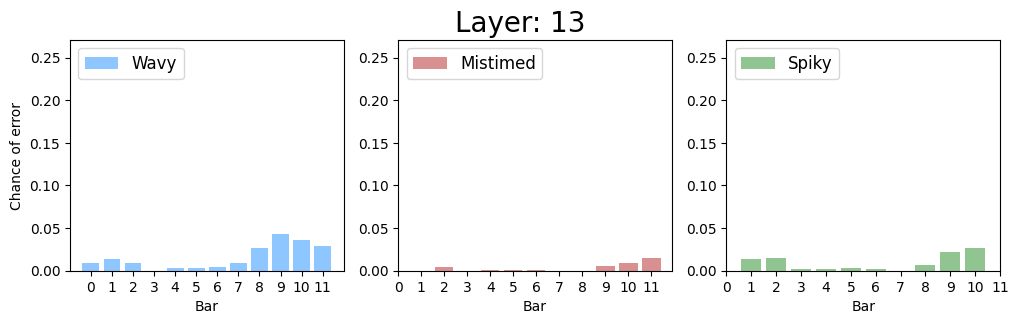

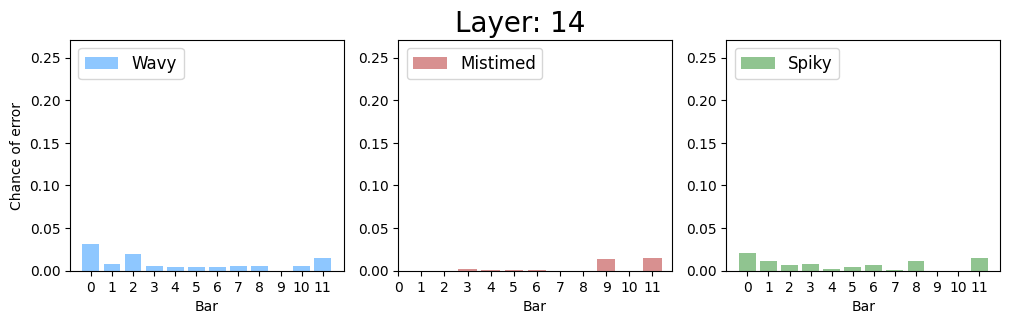

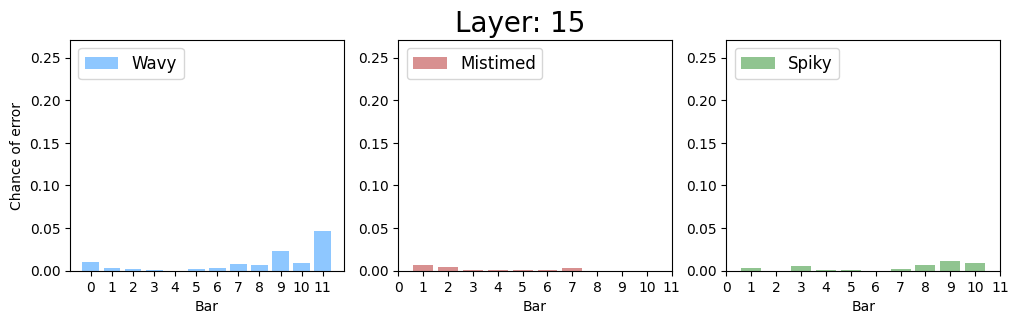

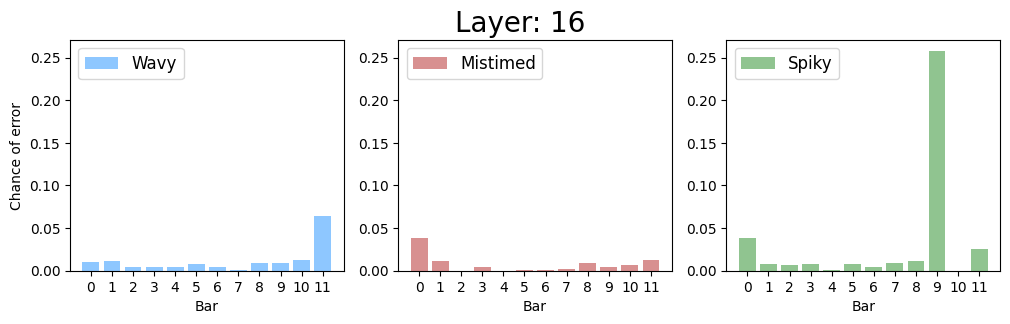

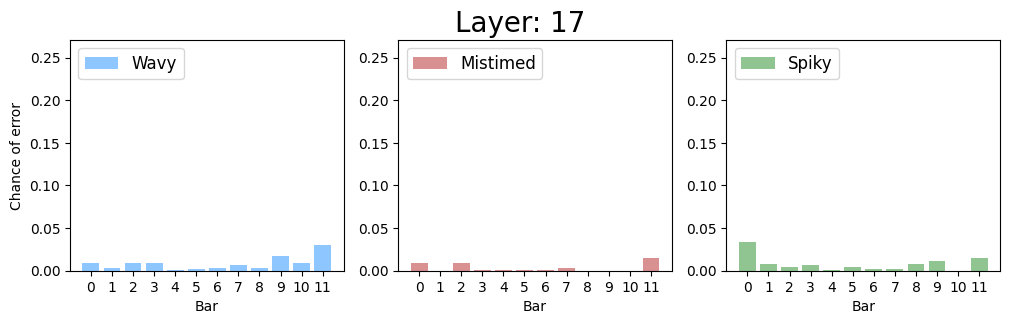

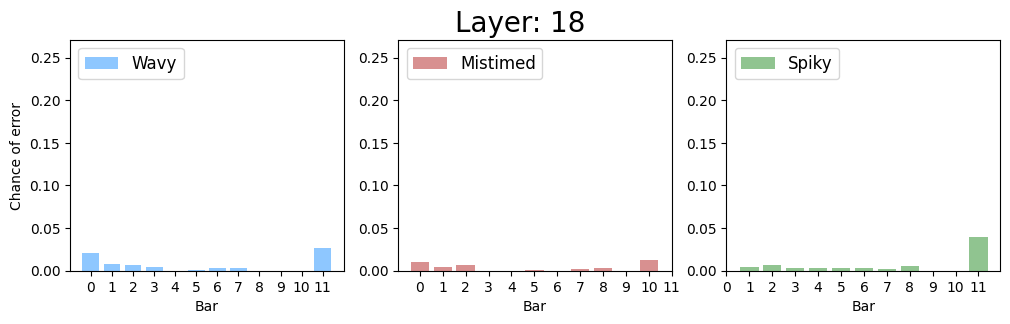

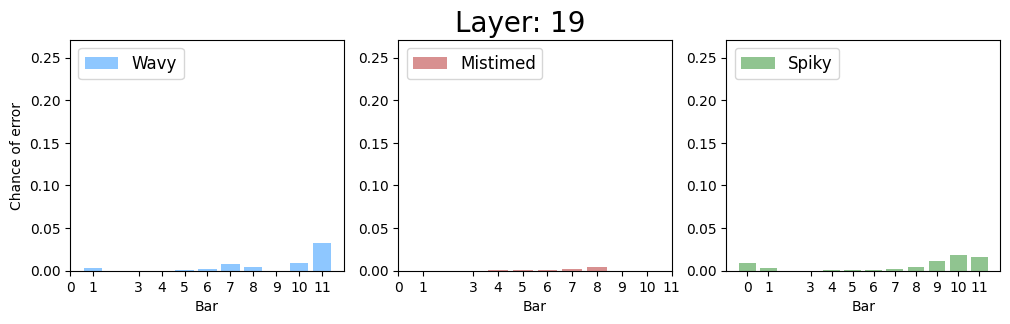

In [34]:
plot_error_by_bar(big_df, True,p_folder, False)